# Baseline Model: Logistic Regression 

We train two simple models on our training data and validate it on our validation data. The two models are:

- logistic regression on the data after removing all observations with NAs
- logistic regression on the data after filling in all NA values with the mean. 

The default L2 regularization is used. This is meant to give us a baseline from which we will show improvements with iterative models. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
import matplotlib.colors as colors
import matplotlib.cm as cmx
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC 
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

from Notebook_helpers import load_data
from Notebook_helpers.modeling_helpers import *

%matplotlib inline

## Read in the Data

In [2]:
df, train, val, test = load_data.load_coral_data(complete=False, CV=False, convert_to_categorical=True)

#### Confirm that there are NAs

In [3]:
# look at how many NAs exist in the data set
df_nas = df.apply(lambda x : x.isna().sum())

# verify that there are no NAs in the data set anymore
df_nas[df_nas > 0]

Complexity    113
Depth          12
dtype: int64

In [4]:
train_nas = train.apply(lambda x : x.isna().sum())
print("Train NAs: \n", train_nas[train_nas > 0])
print("")

val_nas = val.apply(lambda x : x.isna().sum())
print("Val NAs: \n", val_nas[val_nas > 0])

Train NAs: 
 Complexity    75
Depth          8
dtype: int64

Val NAs: 
 Complexity    15
Depth          1
dtype: int64


### Data Prep

##### Drop all rows with NAs

In [5]:
train_X_noNAs = train.dropna()
train_y_noNAs = train_X_noNAs['Regime']
train_X_noNAs = train_X_noNAs.iloc[:, 14:34]

val_X_noNAs = val.dropna()
val_y_noNAs = val_X_noNAs['Regime']
val_X_noNAs = val_X_noNAs.iloc[:, 14:34]

##### Fill in NAs with mean

In [6]:
# isolate the predictors and labels for both the training and test set
train_X = train.iloc[:, 14:34]
train_y = train['Regime']

val_X = val.iloc[:, 14:34]
val_y = val['Regime']

pred_names = df.iloc[:, 14:34].columns

In [7]:
train_X["Complexity"] = train_X["Complexity"].transform(lambda x: x.fillna(x.mean()))
val_X["Complexity"] = val_X["Complexity"].transform(lambda x: x.fillna(x.mean()))

### Standardize the data

In [8]:
scaler = StandardScaler()
scaler_noNas = StandardScaler()

# Fit on training set only.
scaler_noNas.fit(train_X_noNAs.values)

# Apply transform to both the training set and the test set.
train_X_noNAs = scaler_noNas.transform(train_X_noNAs.values)
val_X_noNAs = scaler_noNas.transform(val_X_noNAs.values)

# Fit on training set only.
scaler.fit(train_X.values)

# Apply transform to both the training set and the test set.
train_X = scaler.transform(train_X.values)
val_X = scaler.transform(val_X.values)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by 

### Multinomial logistic regression model on data without NAs

In [10]:
clf_multi = LogisticRegression(solver='newton-cg', multi_class='multinomial')
clf_multi.fit(train_X_noNAs, train_y_noNAs)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

##### Make predictions

In [11]:
val_pred_multi = clf_multi.predict(val_X_noNAs)

##### Evaluate performance

Misclassified samples: 31
Classification Report:
              precision    recall  f1-score   support

           1       0.61      0.71      0.65        24
           2       0.75      0.71      0.73        21
           3       0.55      0.60      0.57        20
           5       0.64      0.47      0.55        19

   micro avg       0.63      0.63      0.63        84
   macro avg       0.64      0.62      0.63        84
weighted avg       0.64      0.63      0.63        84



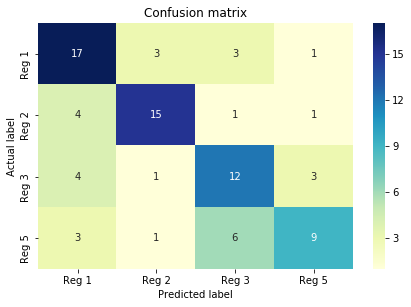

In [12]:
evaluate_performance(val_y_noNAs, val_pred_multi)

### Multinomial logistic regression model on data with NAs filled in as mean

In [13]:
clf_multi = LogisticRegression(solver='newton-cg', multi_class='multinomial')
clf_multi.fit(train_X, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

##### Make predictions

In [14]:
val_pred_multi = clf_multi.predict(val_X)

##### Evaluate performance

Misclassified samples: 33
Classification Report:
              precision    recall  f1-score   support

           1       0.62      0.77      0.69        26
           2       0.80      0.71      0.75        28
           3       0.61      0.68      0.64        25
           5       0.67      0.48      0.56        21

   micro avg       0.67      0.67      0.67       100
   macro avg       0.67      0.66      0.66       100
weighted avg       0.68      0.67      0.67       100



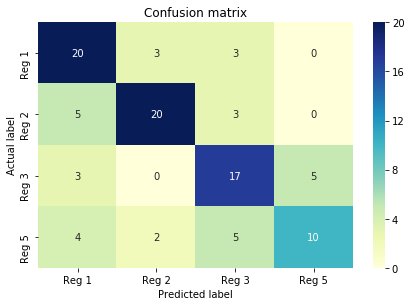

In [15]:
evaluate_performance(val_y, val_pred_multi)

## Findings:

Filling in the missing values for Complexity helped out with the F1 score - it increased the micro F1-score from 0.63 to 0.67. This slight increase may be due to just using more observations. However, we should fill in these missing values.